# Sentiment Analysis of Twittter Airline Tweets
- in-class competition: https://www.kaggle.com/c/airline-sentiment-prediction
- equivalent (but with slightly changed dataset) to: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [15]:
import library as lib
import autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from gensim.models import KeyedVectors

from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

In [6]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sampleSubmission.csv")

In [7]:
df_train.head()

Id airline_sentiment    airline  retweet_count  \
0   0          positive      Delta              0   
1   1          negative     United              0   
2   2          positive  Southwest              0   
3   3          negative  Southwest              0   
4   4          positive  Southwest              0   

                                                text  \
0  @JetBlue I'll pass along the advice. You guys ...   
1  @united I sent you a dm with my file reference...   
2  @SouthwestAir Black History Commercial is real...   
3  @SouthwestAir why am I still in Baltimore?! @d...   
4  @SouthwestAir SEA to DEN. South Sound Volleyba...   

                 tweet_coord   tweet_location               user_timezone  
0                        NaN    Massachusetts  Central Time (US & Canada)  
1                        NaN               ny                       Quito  
2                        NaN       La Florida  Eastern Time (US & Canada)  
3  [39.1848041, -76.6787131]  Tallahassee, FL             America/Chicago  
4                        NaN              NaN  Pacific Time (US & Canada)

In [8]:
emolist = ['⌚️', '☀️', '⛄️', '☺️', '✈️', '👌', '♥️', '✅', '❌', '🇺🇸', '💺', '🔵', '✌️', '🙏', '✔️', '✨', '❤️',
           '❄️', '⭐️', '🌴', '🍷', '🍸', '🎉', '👀', '👋', '👍', '👏', '💗', '👎', '🍻', '👠', '🇬🇧', '👸', '🌞',
           '👺', '👿', '💁', '💕', '💖', '💘', '💙', '💜', '💩', '💯', '😀', '😁', '😭', '😆', '😵', '😂', '😃',
           '🎵', '😍', '😄', '😊', '😡', '😉', '📲', '😬', '😋', '😱', '😎', '😏', '🙌', '😐', '😑', '😒', '😔',
           '😕', '➡️', '😖', '😘', '😜', '😞', '😠', '😢', '😦', '😩', '😫', '😣', '😤', '🐴', '😥', '😲', '😪',
           '💔', '😓', '😮', '😷', '😳', '😻', '🙅']

In [9]:
y_train = [lib.convert_sentiment_to_num(x) for x in df_train['airline_sentiment']]

## Exploratory Analysis

### Distribution of Sentiments

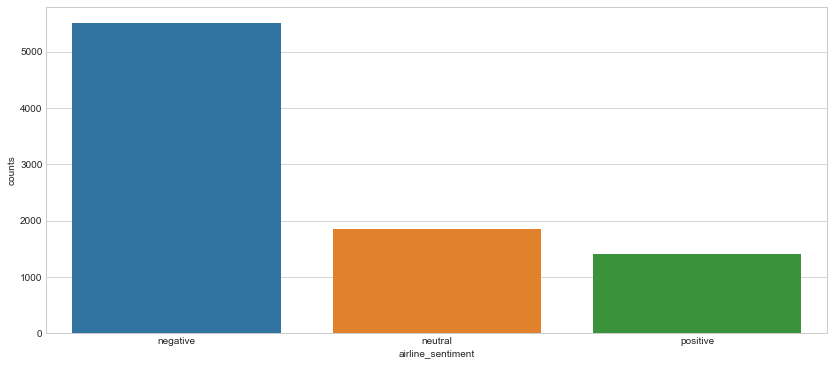

In [97]:
sentiment_count = df_train.groupby('airline_sentiment').size().reset_index(name = 'counts')

sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x="airline_sentiment", y="counts", data=sentiment_count)
plt.show()

### Distribution of Airlines

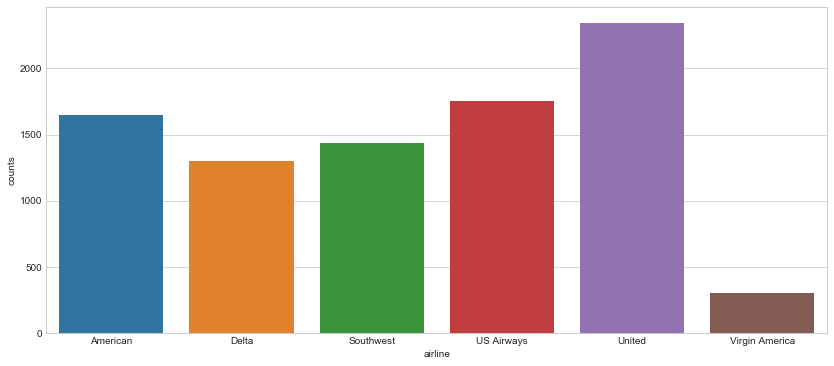

In [98]:
airline_count = df_train.groupby('airline').size().reset_index(name = 'counts')

sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x="airline", y="counts", data=airline_count)
plt.show()

## Distribution of Sentiment per Airline

In [99]:
sentiment_per_airline = df_train.groupby(['airline', 'airline_sentiment']).size().reset_index(name = 'counts')

sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x="airline", y="counts", hue = "airline_sentiment", data=sentiment_per_airline)
plt.show()

## Retweet count

In [131]:
retweet_count = df_train.groupby(['retweet_count', 'airline_sentiment']).size().reset_index(name = 'counts')

sns.set_style("whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
ax = sns.barplot(x="retweet_count", y="counts", hue = "airline_sentiment", data=retweet_count)
plt.legend(loc='upper right')
plt.show()

## Negative wordcloud
Cleaning is explained in next paragraph

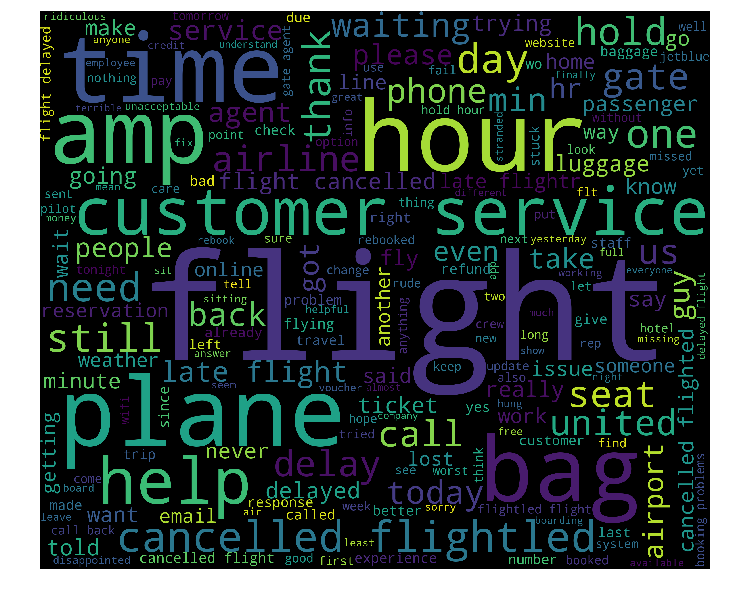

In [132]:
lib.plot_wordcloud(df_train, "negative")

## Positive wordcloud

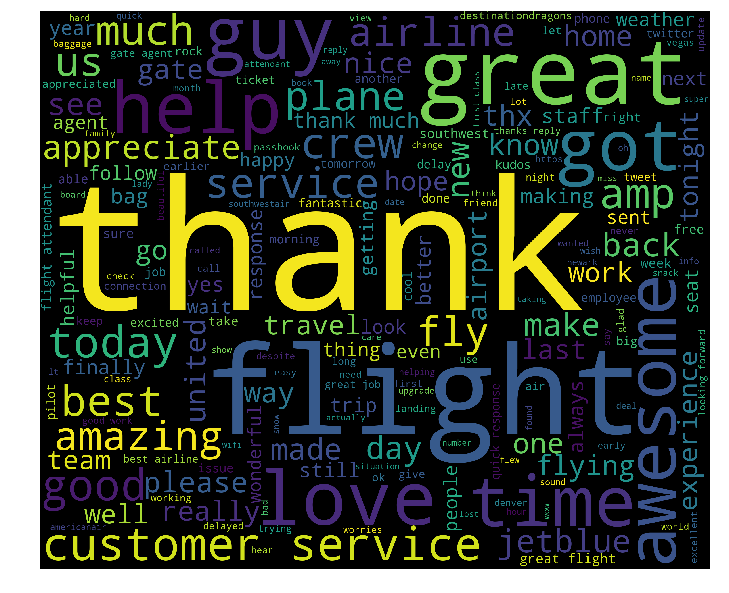

In [134]:
lib.plot_wordcloud(df_train, "positive")

## Data cleaning and tokenization
The cleaning step does the following things:
- remove airport abbreviations such as MIA
- remove airline mentions such as @airline
- remove urls and anything that starts with //
- replace all abbreviations by their full word, for example: "n't" by "not", "what's" by "what is"
- tokenizes the text
- remove punctuation from each token
- removes tokens that are not alphabetic
- removes stopwords, except whitelisted ones, such as "not" and "no
- stems the words

#### Example raw text

In [151]:
start = 140
end = 150

for i in range(start, end):
    print("row:", i, ", sentiment: ", df_train['airline_sentiment'][i], ", text: ", df_train['text'][i],"\n")

row: 140 , sentiment:  negative , text:  @AmericanAir flight 65 delayed over 4 hours on 2/22, had no GF meals despite my early request, attendant seat fell on my leg #badservice 

row: 141 , sentiment:  negative , text:  @AmericanAir you keep returning my call and hanging up when I answer? Help reFlight Booking Problems a flight! 

row: 142 , sentiment:  negative , text:  @USAirways you used to have an evening flight DCA-DSM and an early AM return. Now it's middle of the work day for both. Inconvenient. 

row: 143 , sentiment:  negative , text:  @united flight 5187 to be specific. The last two were probably 30 feet apart and within sight of each other 

row: 144 , sentiment:  positive , text:  @JetBlue Very excited, for the first time this Sunday, March 1 I get to fly #JetBlue flight 123 #Mint from JFK. Looking forward :-) 

row: 145 , sentiment:  negative , text:  @AmericanAir today, after 6 yrs., no longer my preferred airline. 

row: 146 , sentiment:  neutral , text:  @USAirways on 

#### Example clean text

In [152]:
X_=df_train['text'].apply(lambda x: lib.clean_and_tokenize_text(x, stem_words = True, remove_stops = True))    

In [153]:
for i in range(start, end):
    print('row:', i, 'text:', X_[i],"\n")

row: 140 text: ['flight', 'delay', 'hour', 'no', 'meal', 'despit', 'earli', 'request', 'attend', 'seat', 'fell', 'leg', 'badservic'] 

row: 141 text: ['keep', 'return', 'call', 'hang', 'answer', 'help', 'reflight', 'book', 'problem', 'flight'] 

row: 142 text: ['use', 'even', 'flight', 'earli', 'return', 'middl', 'work', 'day', 'inconveni'] 

row: 143 text: ['flight', 'specif', 'last', 'two', 'probabl', 'feet', 'apart', 'within', 'sight'] 

row: 144 text: ['excit', 'first', 'time', 'sunday', 'march', 'get', 'fli', 'jetblu', 'flight', 'mint', 'look', 'forward'] 

row: 145 text: ['today', 'no', 'longer', 'prefer', 'airlin'] 

row: 146 text: ['websit', 'board', 'logan', 'said', 'time', 'went', 'secur', 'got', 'gate'] 

row: 147 text: ['follow'] 

row: 148 text: ['replac', 'beer', 'bravo', 'cheer', 'fattir'] 

row: 149 text: ['yes', 'slc'] 



## Feature matrix generation

The text feature generation is done on the raw text and contains the following steps
- count text length
- count number of mentions such as @anything
- count number of hashtags such as #anything
- count number of capital words
- count number of exclamation or question marks
- count number of urls
- count number of times a reference to a time unit appears, such as hours
- detects whether there is a smiley such as ':)'
- does one-hot-encoding of the airline column

Then from the clean text I generate either a count ngram matrix or a tf-idf ngram matrix, n is taken to be 2. I also
- drop useless columns
- optionally transform to sparse matrix

### Count feature matrix evaluation

In [154]:
X_count_feat = lib.generate_features(df_train)
X_count_feat['airline_sentiment'] = y_train
X_count_feat.head()

has_smiley  num_excl_quest_marks  num_hashtags  num_times  num_urls  \
0           0                     2             0          0         0   
1           0                     0             0          0         0   
2           0                     0             0          0         0   
3           0                     2             0          0         0   
4           0                     1             0          0         1   

   text_length  American  Delta  Southwest  US Airways  United  \
0           10         0      1          0           0       0   
1           29         0      0          0           0       1   
2            9         0      0          1           0       0   
3           18         0      0          1           0       0   
4           15         0      0          1           0       0   

   Virgin America  airline_sentiment  
0               0                  2  
1               0                  0  
2               0                  2  
3               0                  0  
4               0                  2

#### Good example: text_length & num_times

Descriptive stats for text_length
---------------------------------
                    count       mean       std  min   25%   50%   75%   max
airline_sentiment                                                          
0                  5519.0  20.423990  6.068592  2.0  17.0  22.0  25.0  34.0
1                  1857.0  15.134626  7.119528  2.0   9.0  15.0  21.0  34.0
2                  1408.0  14.586648  7.224073  2.0   9.0  15.0  21.0  31.0


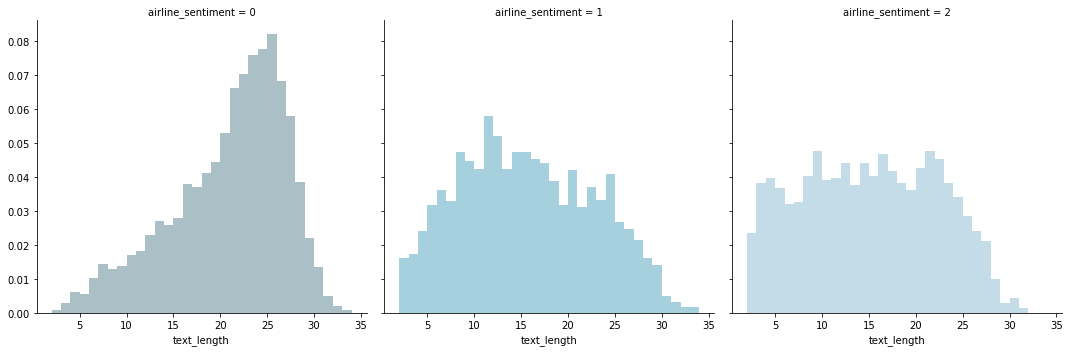

In [155]:
lib.show_dist(X_count_feat, 'text_length')

In [156]:
lib.show_dist(X_count_feat, 'num_times') 

Descriptive stats for num_times
-------------------------------
                    count      mean       std  min  25%  50%  75%  max
airline_sentiment                                                     
0                  5519.0  0.151839  0.394498  0.0  0.0  0.0  0.0  3.0
1                  1857.0  0.015617  0.128291  0.0  0.0  0.0  0.0  2.0
2                  1408.0  0.014915  0.132460  0.0  0.0  0.0  0.0  2.0


#### Removed the two columns
- num_capital_words
- num_mentions

# Modelling
Use logistic regression, svm, random forest, and xgboost

## Logistic Regression

In [160]:
X_train, X_test = lib.generate_train_test_feature_matrices(df_train, df_test, emolist, \
                                                           n=2, sparse_ = False, max_feat = 1000)

In [16]:
print("train shape:", X_train.shape)
print("test shape:", X_test.shape)

train shape: (8784, 1107)
test shape: (5856, 1107)


#### Cross-validate classifier using parameter grid

In [18]:
parameters = {
    'C': [0.25, 0.5, 1.0], # inverse of regularization strength
    'penalty': ['l1', 'l2']
}

clf = lib.grid_search_classifier(X_train, y_train, parameters, crossval=4, classifier = "logistic")

In [19]:
print("cross validation score:", clf.cv_results_['mean_test_score'])
print("best parameters:", clf.best_params_)

cross validation score: [0.77356557 0.78153461 0.78153461 0.78403916 0.78506375 0.78164845]
best parameters: {'C': 1.0, 'penalty': 'l1'}


#### Train on whole training set with best parameters

In [158]:
LogReg = LogisticRegression(C = 1, penalty = 'l1')
LogReg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Generate test data set and predict

In [159]:
predictions_lr = LogReg.predict(X_test)
submission_lr = lib.prepare_and_save_submission(predictions_lr, "submission_lr.csv", submission)

### Kaggle score: 0.79678

## Support Vector Machine

In [109]:
X_train, X_test = lib.generate_train_test_feature_matrices(df_train, df_test, emolist, \
                                                           n=2, sparse_ = False, max_feat = 1000)

#### Cross validate svm with paramter grid

In [110]:
parameters = {'C': [0.01, 0.1, 1, 10], # regularization
              'gamma' : [0.001, 0.01, 0.1, 1]} # kernel coefficient

clf = lib.grid_search_classifier(X_train, y_train, parameters, crossval=4, classifier = "svm")

In [111]:
print("cross validation score:", clf.cv_results_['mean_test_score'])
print("best parameters:", clf.best_params_)

cross validation score: [0.62830146 0.62830146 0.62830146 0.62830146 0.62830146 0.65050091
 0.66791894 0.62830146 0.65596539 0.72745902 0.74032332 0.64435337
 0.74351093 0.77925774 0.75512295 0.6489071 ]
best parameters: {'C': 10, 'gamma': 0.01}


#### Train on whole training set with best parameters

In [33]:
svm = SVC(C = 10, gamma = 0.01)
svm.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Generate test data set and predict

In [35]:
predictions_svm = svm.predict(X_test)
submission_svm = lib.prepare_and_save_submission(predictions_svm, "submission_svm.csv", submission)

### Kaggle score: 0.78039

## Random Forest

In [112]:
X_train, X_test = lib.generate_train_test_feature_matrices(df_train, df_test, emolist, \
                                                           n=2, sparse_ = False, max_feat = 1000)

#### Cross validate random forest with parameter grid

In [122]:
parameters = {'n_estimators': [350, 400, 500], 
              'max_features': ['sqrt'],
              'min_samples_leaf':[1,2],
              'min_samples_split':[3,4],
              'max_depth' : [70, 100],
              'bootstrap': [False]
             } 

clf = lib.grid_search_classifier(X_train, y_train, parameters, crossval=3, classifier = "rf")

In [123]:
print("cross validation score:", clf.cv_results_['mean_test_score'])
print("best parameters:", clf.best_params_)

cross validation score: [0.76616576 0.76514117 0.76605191 0.76400273 0.76536885 0.76696266
 0.76081512 0.7602459  0.76195355 0.7620674  0.76172587 0.76183971
 0.76320583 0.76388889 0.76468579 0.76479964 0.76468579 0.76616576
 0.76081512 0.76388889 0.76161202 0.76252277 0.76172587 0.76115665]
best parameters: {'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 500}


#### Train on whole training set with best parameters

In [127]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 70, max_features = 'sqrt', min_samples_leaf = 1, 
                            min_samples_split = 10, bootstrap = False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=70, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Generate test data set and predict

In [128]:
predictions_rf = rf.predict(X_test)
submission_rf = lib.prepare_and_save_submission(predictions_rf, "submission_rf.csv", submission)

### Kaggle score: 0.77015

## XGBoost

#### Generate data in sparse format

In [7]:
X_train, X_test = lib.generate_train_test_feature_matrices(df_train, df_test, emolist, n = 2, sparse_ = True)
print("train shape:", X_train.shape)
print("test shape:", X_test.shape)

train shape: (8784, 49614)
test shape: (5856, 49614)


#### Cross validate xgboost to find number of rounds

In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth':3, 'eta':1, 'silent':0, 'num_class':3, 'objective':'multi:softmax'}
xgb.cv(param, dtrain, num_boost_round=250, nfold=4)

#### Train xgboost

In [16]:
clf_xgb = xgb.train(param, dtrain, num_boost_round=200) 

#### Predict with xgboost

In [17]:
dtest = xgb.DMatrix(X_test)
prediction_xgb = clf_xgb.predict(dtest)

#### Submission with xgboost

In [18]:
submission_xgb = lib.prepare_and_save_submission(prediction_xgb, "submission_xgb.csv", submission)

### Kaggle score: 0.78995

# Word embeddings with LSTM

### Parameters

In [161]:
EMBEDDING_FILE = '/Users/peterweber/Projects/AIA_tech_test/embeddings/GoogleNews-vectors-negative300.bin'
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM =300

### Prepare data structures

In [162]:
X_train = df_train['text'].apply(lambda x: lib.clean_and_tokenize_text(x, remove_stops=False, stem_words=False))    
X_test = df_test['text'].apply(lambda x: lib.clean_and_tokenize_text(x, remove_stops=False, stem_words=False)) 
X = X_train.tolist() + X_test.tolist()

#### Convert tokenized sentences to padded sequence of indices, every index referes to a word

In [163]:
## Initialize Keras tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

In [164]:
## tokenize both the training and test set
tokenizer.fit_on_texts(X)

In [166]:
## Give index to every unique token
word_index = tokenizer.word_index
words = len(word_index) + 1
print('Found %s unique tokens' % len(word_index))

Found 10468 unique tokens


In [49]:
## write sentence as sequence of indices
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

In [169]:
## pad with 0's at maximum length
train_pad = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
test_pad = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(y_train)
print('Shape of train tensor:', train_pad.shape)
print('Shape of test tensor:', test_pad.shape)
print('Shape of label tensor:', labels.shape)

Shape of train tensor: (8784, 30)
Shape of test tensor: (5856, 30)
Shape of label tensor: (8784,)


### Create train and validation set

In [171]:
X_train_emb, X_val_emb, y_train_emb, y_val_emb = train_test_split(train_pad, y_train, test_size = 0.01, random_state=0)

In [120]:
# convert labels to onehot-encoding
y_train_onehot = to_categorical(y_train_emb)
y_val_onehot = to_categorical(y_val_emb)

### Prepare embeddings

In [121]:
## load word to vector representation from Google Corpus
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [122]:
## Construct embedding for every word based on the embeddings corpus
## In matrix every row represents the embedding of a word
embedding_matrix = lib.construct_embedding_matrix(word2vec, EMBEDDING_DIM, word_index)

Null word embeddings: 2059
These are words that don't exist in the Google Corpus but in our data!!!


### Define model

In [123]:
model1 = Sequential()
model1.add(Embedding(words, 
                  EMBEDDING_DIM, 
                  weights = [embedding_matrix], 
                  input_length=MAX_SEQUENCE_LENGTH, 
                  trainable = False))
model1.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2)) # 200 output units
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(Dense(100, activation = 'relu'))
model1.add(Dropout(0.2))
model1.add(BatchNormalization())
model1.add(Dense(3, activation = 'softmax'))
model1.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 30, 300)           3140700   
_________________________________________________________________
lstm_8 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 200)               800       
_________________________________________________________________
dense_11 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 100)               400       
__________

### Fit model

In [124]:
hist1 = model1.fit(X_train_emb, y_train_onehot, \
        validation_data=(X_val_emb, y_val_onehot), \
        epochs=50, batch_size=2048, shuffle=True)

Train on 8696 samples, validate on 88 samples
Epoch 1/50
8696/8696 [==============================] - 19s 2ms/step - loss: 1.3135 - acc: 0.4391 - val_loss: 0.7904 - val_acc: 0.6705
Epoch 2/50
8696/8696 [==============================] - 13s 2ms/step - loss: 1.0286 - acc: 0.5856 - val_loss: 0.7525 - val_acc: 0.6705
Epoch 3/50
8696/8696 [==============================] - 12s 1ms/step - loss: 0.9213 - acc: 0.6161 - val_loss: 0.7865 - val_acc: 0.6818
Epoch 4/50
8696/8696 [==============================] - 12s 1ms/step - loss: 0.8146 - acc: 0.6693 - val_loss: 0.9648 - val_acc: 0.7386
Epoch 5/50
8696/8696 [==============================] - 12s 1ms/step - loss: 0.7575 - acc: 0.7080 - val_loss: 0.7412 - val_acc: 0.8182
Epoch 6/50
8696/8696 [==============================] - 13s 1ms/step - loss: 0.7172 - acc: 0.7324 - val_loss: 0.6270 - val_acc: 0.8182
Epoch 7/50
8696/8696 [==============================] - 12s 1ms/step - loss: 0.6965 - acc: 0.7415 - val_loss: 0.5745 - val_acc: 0.7955
Epoch 8/5

### Predictions

In [127]:
predictions_lstm = model1.predict_classes(test_pad)

In [128]:
predictions_lstm = lib.prepare_and_save_submission(predictions_lstm, "predictions_lstm.csv", submission)

### Kaggle score: 0.78893

# Next steps

- Compare against positive and negative word dictionary
- Minority sampling
- POS tagging
- Train word2vec model on this dataset